# Working with Arable Data

In [12]:
import arablepy
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import numpy as np

from datetime import date
today = date.today()
d1 = today.strftime("%Y-%m-%d")

import matplotlib.pyplot as plt

import ee
import geemap
# import contextily as cx

## Setup 
### Create client

#### Credentials
Enter email and password provided

In [371]:
email = 'email'
password = 'pw'

#### Client

In [4]:
client = arablepy.ArableClient()
client.connect(email=email, password=password)

#### Available data

What datasets are available through the API? The following provides a list of the datasets. 

In [376]:
client.schema(df=True)

,0
0,aux_raw
1,daily
2,health
3,hourly
4,irrigation_runtime_daily
5,irrigation_runtime_hourly
6,local_hourly
7,location_irrigation_forecast_daily
8,sentek_daily
9,sentek_hourly


The daily dataset provides these variables:

In [377]:
client.schema('daily', df=True)

,column_name,data_type,description
0,cl,real,Chlorophyll Index (unitless index)
1,crop_water_demand,real,Crop water demand (mm/day)
2,device,text,"Arable device ID (e.g., A000176)"
3,dli,real,Daily Light Integral
4,ea,double precision,Actual Water Vapor Pressure (kPa)
5,et,real,Evapotranspiration (ETo) (mm)
6,etc,double precision,Crop Evapotranspiration (mm)
7,kc,double precision,"Crop coefficient, Kc (unitless)"
8,lat,real,Latitude (decimal degree)
9,lfairdelta,real,Leaf to air temperature difference (C)


### List of devices

We are going to work with data from our project in Zambia, so we need to get a list of devices first. 

In [5]:
vars = ['current_location', 'name', 'last_seen', 'state', 'batt_pct', 
        'signal_strength']
devices = client.devices(df=True, locations = True, limit=4000)[vars]

We need to go a little extra work to get the devices coordinates and countries. We have devices in both Kenya and Tanzania.

In [6]:
locations = []
for idx, row in devices.iterrows():
    loc = row['current_location']
    gps = loc.get('gps')
    if gps is None:
        gps = [np.isnan, np.isnan]
    country = loc.get('country')
    name = loc.get('device_name')
    locations.append({
        'row': idx, 'name': name, 'country': country, 'x': gps[0], 
        'y': gps[1]
    })
locations = pd.DataFrame(locations)
devices = locations.merge(devices.drop('current_location', axis = 1), 
                          on='name', how='left')

#### Convert to geodataframe

In [8]:
# drop some missing records first, and one in US
devices = devices.mask(devices.eq('None')).dropna()
devices = devices[devices['country'] != 'US']

devices_gdf = gpd.GeoDataFrame(
    devices, geometry=gpd.points_from_xy(devices['x'], devices['y'])
).set_crs(4326, allow_override=True)

#### Plot device locations

Get map center first

In [9]:
%%capture
def minmax(centroid):
    return np.percentile(centroid, [0, 100])
xy = [np.mean(minmax(devices_gdf.centroid.y)), 
      np.mean(minmax(devices_gdf.centroid.x))]

Initialize EarthEngine

First, from your terminal run this and follow the steps
```bash
earthengine authenticate
```

That will give you a code after asking which google account you want to use and whether to trust this

Then run this. 

In [2]:
ee.Initialize()

In [14]:
devices_ee = geemap.geopandas_to_ee(devices_gdf)  # gpd to ee
Map = geemap.Map(center=xy, zoom=5)
Map.add_basemap('HYBRID')
Map.addLayer(devices_ee, {'color': 'red'}, "Mark locations")
Map

Map(center=[-8.25767, 32.3134095], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox…

#### Subset to active devices in Zambia

Those in Zambia

In [15]:
zam_devices = devices_gdf[
    (devices_gdf['country'] == "ZM") & (devices_gdf['y'] < 0)
]
zam_devices

,row,name,country,x,y,last_seen,state,batt_pct,signal_strength,geometry
0,0,A000709,ZM,28.249519,-15.54956,2022-03-21T10:04:51.615680+00:00,Active,48.00,Very Good,POINT (28.24952 -15.54956)
5,5,A000693,ZM,28.249571,-15.54959,2022-03-21T10:22:59.815083+00:00,Active,10.00,Very Good,POINT (28.24957 -15.54959)
8,8,A000721,ZM,28.249331,-15.54972,2022-03-21T10:47:27.049946+00:00,Active,27.00,Very Good,POINT (28.24933 -15.54972)
10,10,A000784,ZM,28.249241,-15.54974,2022-03-21T10:11:27.677143+00:00,Active,24.00,Very Good,POINT (28.24924 -15.54974)
16,16,A000415,ZM,28.249559,-15.54957,2022-03-21T10:52:01.254037+00:00,Active,22.00,Very Good,POINT (28.24956 -15.54957)
17,17,A000408,ZM,28.249269,-15.54974,2022-03-21T05:59:02.457225+00:00,Active,11.80,Very Good,POINT (28.24927 -15.54974)
27,27,A000708,ZM,27.07257,-16.83851,2021-02-11T17:39:25.068081+00:00,Dormant,87.00,Very Good,POINT (27.07257 -16.83851)
29,29,A000414,ZM,28.249281,-15.54796,2020-10-17T12:49:01.538957+00:00,Dormant,10.00,Good,POINT (28.24928 -15.54796)
50,50,A000421,ZM,28.249439,-15.54783,2020-10-26T07:54:06.972652+00:00,Dormant,6.00,Very Good,POINT (28.24944 -15.54783)
55,55,A000299,ZM,28.24929,-15.54802,2020-11-20T16:20:23.037023+00:00,Dormant,93.00,Weak,POINT (28.24929 -15.54802)


## Collect data from devices

In [16]:
active_devices = zam_devices[zam_devices['last_seen'] > '2022-01-01']

devnames = [name for name in active_devices['name']]
daily_df = client.data('daily', devices=devnames, start_time='2021-10-01', 
                       end_time=d1, df=True)

Reorder the columns to move the device name, location, and observation time to the left hand side

In [17]:
names = daily_df.columns.values
firstnames = ['device', 'lat', 'long', 'time']
names_reorder = firstnames
[names_reorder.append(name) for name in names if name not in firstnames]
daily_df = daily_df[names_reorder]
daily_df['time'] = pd.to_datetime(daily_df['time']).dt.date
daily_df = daily_df.convert_dtypes()  # convert datatypes

Let's count how many observations per device 

In [18]:
daily_df[['device', 'time']].groupby(['device']).count()

,time
device,
A000301,125
A000407,82
A000408,126
A000415,123
A000434,130
A000477,85
A000693,118
A000709,125
A000721,130


### Plot time series

And let's make a plot for each device for rainfall and a VI

#### Rainfall

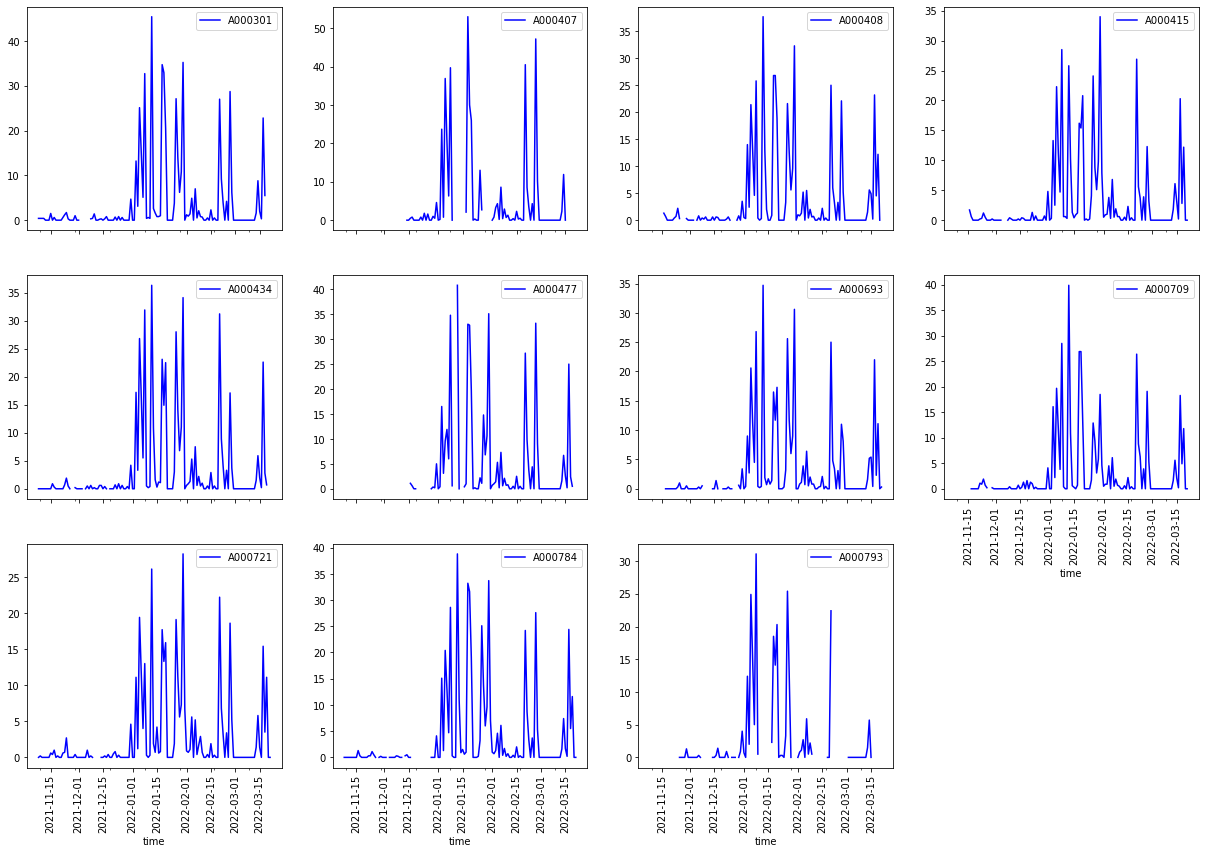

In [19]:
active_devnames = np.unique(active_devices['name'])
nrow = 3 
ncol = int(np.ceil(len(active_devnames) / nrow))

pd.pivot_table(
    daily_df.reset_index(), index='time', columns='device', values='precip'
).plot(
    subplots=True, layout=(nrow, ncol), figsize=(21, 14), color='blue', rot=90
)
None

#### NDVI

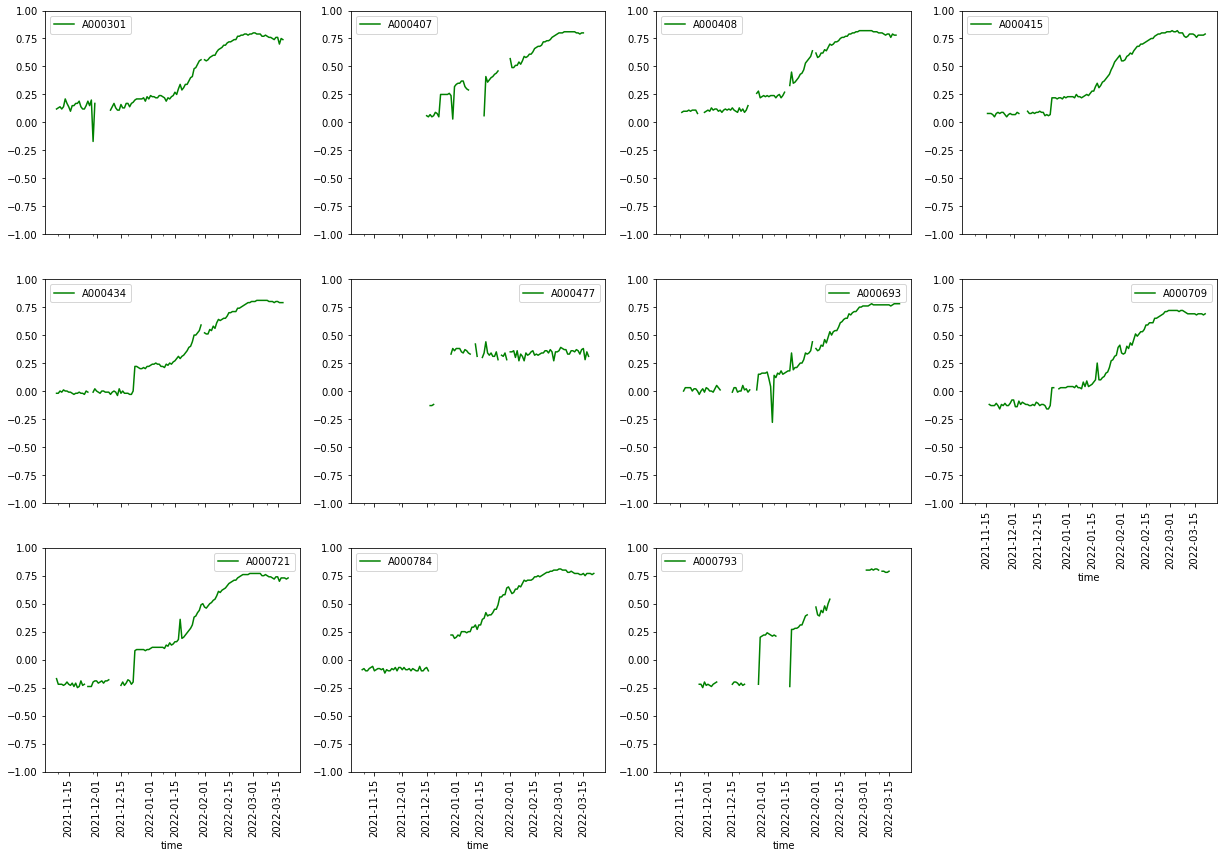

In [20]:
pd.pivot_table(
    daily_df.reset_index(), index='time', columns='device', values='ndvi'
).plot(
    subplots=True, layout=(nrow, ncol), figsize=(21, 14), color='green', 
    rot=90, ylim=(-1, 1)
)
None

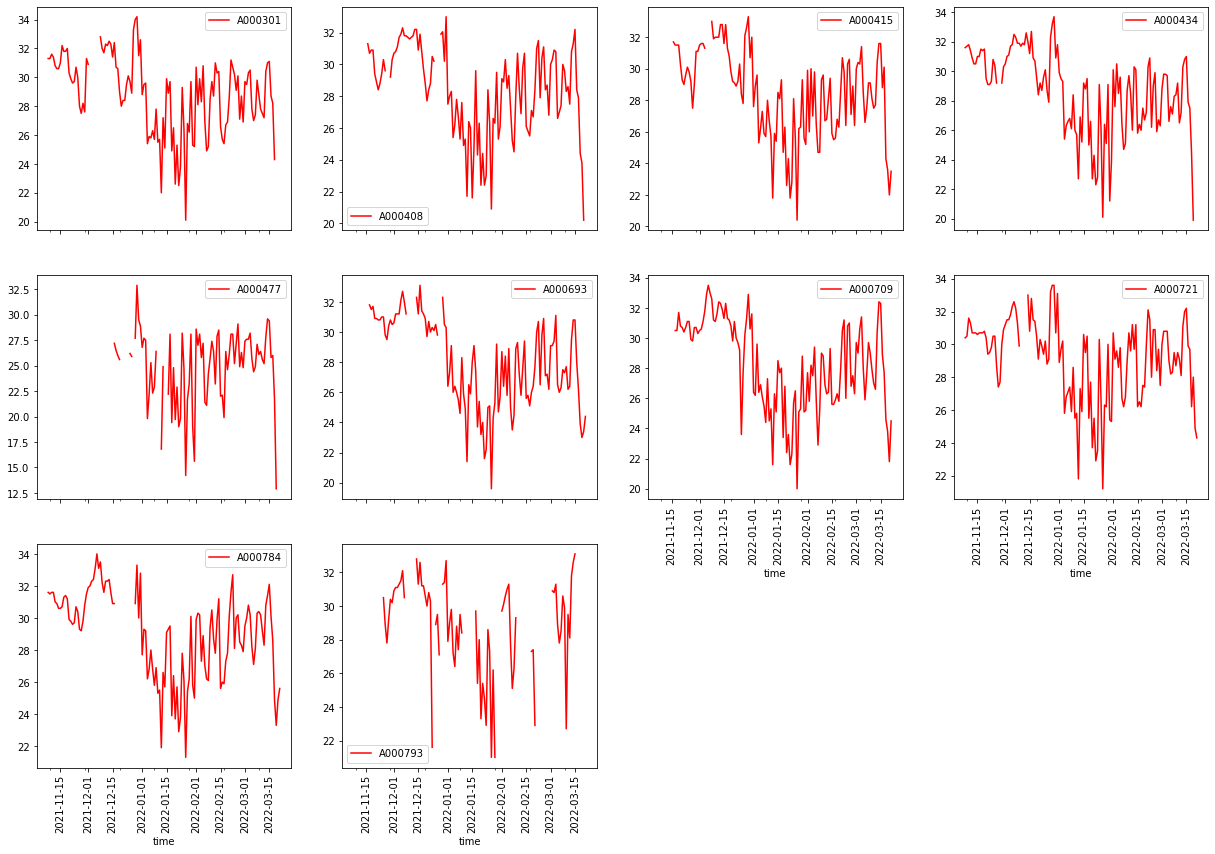

In [21]:
pd.pivot_table(
    daily_df.reset_index(), index='time', columns='device', values='maxt'
).plot(
    subplots=True, layout=(nrow, ncol), figsize=(21, 14), color='red', 
    rot=90#, ylim=(-1, 1)
)
None

## Compare to satellite data

Let's compare the Mark data in Zambia to several sets of satellite imagery: 

1. CHIRPS precipitation
2. Sentinel 1 (for VIs)
3. MODIS Land Surface Temperature

Set up study region first

In [52]:
%%capture

# get more accurate coordinates for devices
devices_xy = daily_df[['device', 'lat', 'long']]\
    .groupby('device')\
    .median(['lat', 'long'])\
    .rename(columns={'long': 'x', 'lat': 'y'})

devices_xy_gdf = gpd.GeoDataFrame(
    devices_xy, geometry=gpd.points_from_xy(devices_xy['x'], devices_xy['y'])
).set_crs(4326).drop(['x', 'y'], axis=1)

geom = box(*active_devices.total_bounds + [-0.1, -0.1, 0.1, 0.1])
aoi = gpd.GeoDataFrame({"ID": 1, "geometry": [geom]}).set_crs(4326)
xy = [np.mean(minmax(aoi.centroid.y)), 
      np.mean(minmax(aoi.centroid.x))]

### Function for extracting time series

In [224]:
def fill(img, ini):
    
    def set_date(ft):
        return ft.set("date", date)   
    
    #type cast
    inift = ee.FeatureCollection(ini);

    #gets the values for the points in the current img
    ft2 = ee.FeatureCollection(img.reduceRegions(fc, ee.Reducer.first(), 30))  
  
    #gets the date of the img
    date = img.date().format();

    #writes the date in each feature
    ft3 = ft2.map(set_date)
    
    #merges the FeatureCollections
    return inift.merge(ft3)

Coerce aoi and devices GeoDataframes to ee object

In [184]:
aoi_ee = geemap.geopandas_to_ee(aoi)  # gpd to ee
devices_xy_ee = geemap.geopandas_to_ee(devices_xy_gdf) 

### CHIRPs

Cut CHIRPS data down to AOI around sensors

In [179]:
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
           .filterDate('2021-12-15', d1)\
           .filterBounds(aoi_ee)
chirps_aoi = chirps.map(lambda img: img.clip(aoi_ee))

Extract the values from the rainfall images

In [225]:
ft = ee.FeatureCollection(ee.List([]))
fc = devices_xy_ee
newft = ee.FeatureCollection(chirps_aoi.iterate(fill, ft))

# convert back from ee to pandas
rainfall_ts = geemap.ee_to_pandas(newft)
rainfall_ts = rainfall_ts.rename(columns={"first": "rainfall"})
rainfall_ts['date'] = pd.to_datetime(rainfall_ts['date']).dt.date

Since the pixel is much larger than the points were the pods are, we can just average by date. 

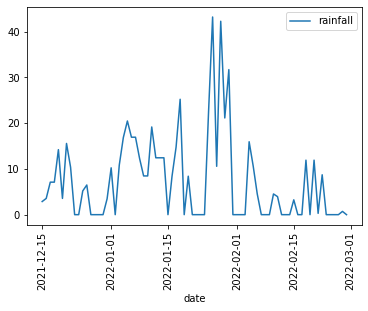

In [251]:
rainfall_ts.groupby('date').mean().plot(rot=90)
None

### Sentinel 1

In [230]:
s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
       .filterDate('2021-12-15', d1) \
       .filterBounds(aoi_ee)

s1_aoi = s1.map(lambda img: img.clip(aoi_ee))

Extract values

In [231]:
Map = geemap.Map(center=xy, zoom=11)
Map.add_basemap('HYBRID')
Map.addLayer(s1_aoi.select('VV').first(), {'min': -15, 'max': 15}, 'S1')
Map.addLayer(devices_xy_ee, {'color': 'red'}, 'Marks')
# Map

In [226]:
ft2 = ee.FeatureCollection(ee.List([]))
fc = devices_xy_ee
newft2 = ee.FeatureCollection(s1_aoi.iterate(fill, ft2))

# convert back from ee to pandas
s1_ts = geemap.ee_to_pandas(newft2)
s1_ts = s1_ts.drop('angle', axis=1)
s1_ts['date'] = pd.to_datetime(s1_ts['date']).dt.date
s1_ts

,date,VV,VH,angle,device
0,2021-12-19T16:33:00,-6.944016,-12.780345,34.935867,A000301
1,2021-12-19T16:33:00,-4.911248,-16.867486,34.937317,A000407
2,2021-12-19T16:33:00,-7.519290,-14.230091,34.933430,A000408
3,2021-12-19T16:33:00,-6.944016,-12.780345,34.935867,A000415
4,2021-12-19T16:33:00,-6.944016,-12.780345,34.935867,A000434
5,2021-12-19T16:33:00,-6.944016,-12.780345,34.935867,A000477
6,2021-12-19T16:33:00,-6.944016,-12.780345,34.935867,A000693
7,2021-12-19T16:33:00,-6.944016,-12.780345,34.935867,A000709
8,2021-12-19T16:33:00,-6.322258,-16.413729,34.935375,A000721
9,2021-12-19T16:33:00,-7.519290,-14.230091,34.933430,A000784


In [234]:
s1_ts.groupby('date').mean()#.plot(rot=90)

,VV,VH,angle
date,,,
2021-12-19T16:33:00,-6.995289,-14.030445,34.935422


## Comparisons

,date,rainfall,device
0,2021-12-15,2.800844,A000301
1,2021-12-15,2.800844,A000407
2,2021-12-15,2.800844,A000408
3,2021-12-15,2.800844,A000415
4,2021-12-15,2.800844,A000434
...,...,...,...
831,2022-02-28,0.000000,A000693
832,2022-02-28,0.000000,A000709
833,2022-02-28,0.000000,A000721
834,2022-02-28,0.000000,A000784


In [254]:
pre_comp = daily_df.rename(columns = {'time': 'date'})[['device', 'date', 'precip', 'ndvi']] \
                   .groupby('date').mean() \
                   .merge(rainfall_ts.groupby('date').mean(), how='inner', on='date')

<AxesSubplot:xlabel='date'>

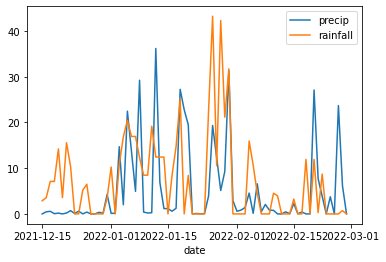

In [257]:
pre_comp[['precip', 'rainfall']].plot()